# Data trimming analysis
Uses analysis of variance to quantify improvement of data quality after trimming one second off of each end of each csv.

Processing data/Timo/base 2025-06-07 12-17-44.zip...
Processing data/Timo/200 ml 2025-06-07 12-52-34.zip...
Processing data/Timo/230ml 2025-06-06 16-22-45.zip...
Processing data/Timo/base 2025-06-06 15-45-11.zip...

Processed 4 zip files
Variance reduction statistics:
  Mean reduction: 25.36%
  Median reduction: 28.02%
  Std deviation: 15.82%


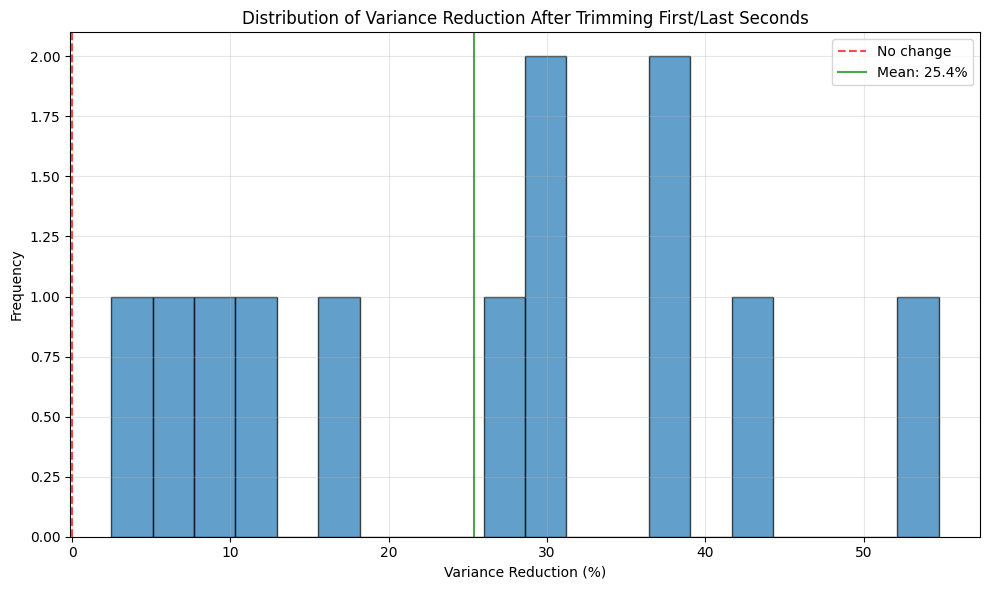


Results saved to data_trimmed
Histogram saved as 'variance_reduction_histogram.png'
Detailed analysis saved as 'variance_analysis.json'


In [5]:
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json


def trim_timeseries_data(df):
    """Trim first and last second of timeseries data"""
    if df.empty:
        return df
    
    start_time = df.iloc[0, 0]  # First time value
    end_time = df.iloc[-1, 0]  # Last time value
    
    # Find indices for trimming
    trim_start_time = start_time + 1.0
    trim_end_time = end_time - 1.0
    
    # Filter data
    trimmed_df = df[(df.iloc[:, 0] >= trim_start_time) & (df.iloc[:, 0] <= trim_end_time)]
    return trimmed_df

def calculate_variance_metrics(df):
    """Calculate variance for all sensor columns (excluding time)"""
    if df.empty or len(df.columns) <= 1:
        return {}
    
    # Skip time column (first column), calculate variance for sensor data
    sensor_data = df.iloc[:, 1:]
    variances = {}
    
    for col in sensor_data.columns:
        variances[col] = np.var(sensor_data[col])
    
    # Overall variance (mean of all sensor variances)
    variances['overall'] = np.mean(list(variances.values()))
    return variances

def process_zip_file(zip_path, output_dir):
    """Process a single zip file: trim data and calculate variance metrics"""
    results = {'file': zip_path.name, 'original_var': {}, 'trimmed_var': {}}
    
    # Create output directory
    output_zip_path = output_dir / zip_path.name.replace('.zip', '_trimmed.zip')
    
    with zipfile.ZipFile(zip_path, 'r') as zip_in:
        with zipfile.ZipFile(output_zip_path, 'w') as zip_out:
            
            for file_info in zip_in.infolist():
                if file_info.filename.startswith('meta/'):
                    # Copy meta folder unchanged
                    zip_out.writestr(file_info, zip_in.read(file_info))
                elif file_info.filename.endswith('.csv'):
                    # Process CSV files
                    with zip_in.open(file_info) as csv_file:
                        df = pd.read_csv(csv_file)
                        
                        # Ensures correct handling of scientific notation
                        for col in df.columns[1:]:
                            df[col] = pd.to_numeric(df[col], errors='coerce')

                        # Calculate original variance
                        orig_var = calculate_variance_metrics(df)
                        results['original_var'][file_info.filename] = orig_var
                        
                        # Trim data
                        trimmed_df = trim_timeseries_data(df)
                        
                        # Calculate trimmed variance
                        trimmed_var = calculate_variance_metrics(trimmed_df)
                        results['trimmed_var'][file_info.filename] = trimmed_var
                        
                        # Write trimmed data to new zip
                        csv_string = trimmed_df.to_csv(index=False)
                        zip_out.writestr(file_info.filename, csv_string)
    
    return results

# Setup paths
data_dirs = [Path('./data/Timo')] 
# data_dirs.append(['./data/Nathaniel']) # just using timo data for now.
output_dir = Path('./data_trimmed')
output_dir.mkdir(exist_ok=True)

# Create subdirectories
for data_dir in data_dirs:
    if data_dir.exists():
        (output_dir / data_dir.name).mkdir(exist_ok=True)

all_results = []
variance_deltas = []

# Process all zip files
for data_dir in data_dirs:
    if not data_dir.exists():
        print(f"Warning: {data_dir} does not exist, skipping...")
        continue
        
    output_subdir = output_dir / data_dir.name
    
    for zip_file in data_dir.glob('*.zip'):
        print(f"Processing {zip_file}...")
        results = process_zip_file(zip_file, output_subdir)
        all_results.append(results)
        
        # Calculate variance deltas for each CSV file
        for csv_name in results['original_var'].keys():
            orig_overall = results['original_var'][csv_name].get('overall', 0)
            trim_overall = results['trimmed_var'][csv_name].get('overall', 0)
            delta = (orig_overall - trim_overall) / orig_overall * 100  # Percentage reduction
            variance_deltas.append({
                'file': f"{results['file']}_{csv_name}",
                'delta_percent': delta,
                'sensor_type': csv_name.replace('.csv', '')
            })

# Print summary statistics
print(f"\nProcessed {len(all_results)} zip files")
print(f"Variance reduction statistics:")
deltas = [d['delta_percent'] for d in variance_deltas]
print(f"  Mean reduction: {np.mean(deltas):.2f}%")
print(f"  Median reduction: {np.median(deltas):.2f}%")
print(f"  Std deviation: {np.std(deltas):.2f}%")

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(deltas, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Variance Reduction (%)')
plt.ylabel('Frequency')
plt.title('Distribution of Variance Reduction After Trimming First/Last Seconds')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No change')
plt.axvline(x=np.mean(deltas), color='green', linestyle='-', alpha=0.7, 
            label=f'Mean: {np.mean(deltas):.1f}%')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'variance_reduction_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Save detailed results
with open(output_dir / 'variance_analysis.json', 'w') as f:
    json.dump({
        'summary': {
            'mean_reduction_percent': float(np.mean(deltas)),
            'median_reduction_percent': float(np.median(deltas)),
            'std_reduction_percent': float(np.std(deltas))
        },
        'detailed_results': variance_deltas
    }, f, indent=2)

print(f"\nResults saved to {output_dir}")
print("Histogram saved as 'variance_reduction_histogram.png'")
print("Detailed analysis saved as 'variance_analysis.json'")
